'''env: DL_image'''
import os
# Pretrained Inception V3:
## settings
import torch
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np

suf = "1205_074135"
img_title = "HAM10000"
n_classes = 7
data_root = "C:/Users/20878/221Project/HAM10K/tmp/HAM10000"

## Define dataset and transformations
data_dir = "C:/Users/20878/221Project/HAM10K/test_dir"
trans_test = 311
transform = transforms.Compose([transforms.Resize((trans_test,trans_test)),
                                   transforms.CenterCrop((299, 299)),
                                   transforms.ToTensor(),
                                   transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
                                  ])

dataset = datasets.ImageFolder(root=data_dir, transform=transform)

## Create DataLoader
dataloader = DataLoader(dataset, batch_size=32, shuffle=False, num_workers=2)

## Load the model
from torchvision import models
import torch.nn as nn
model = models.inception_v3(pretrained=False)
model.fc = nn.Linear(model.fc.in_features, n_classes)
model.AuxLogits.fc = nn.Linear(model.AuxLogits.fc.in_features, n_classes)

md_name = "best_test_HAM10000_"+ suf+ ".pth"
state_dict = torch.load(os.path.join(data_root, suf, md_name), map_location=torch.device('cpu'))
model.load_state_dict(state_dict)
model.eval() 

## Compute softmax outputs and collect labels
softmax_outputs = []
labels = []

with torch.no_grad():
    for images, label in dataloader:
        outputs = model(images)
        softmax_probs = F.softmax(outputs, dim=1)
        softmax_outputs.append(softmax_probs.cpu().numpy())
        labels.append(label.numpy())

## Convert lists to matrices
softmax_matrix = np.vstack(softmax_outputs)
label_vector = np.concatenate(labels)
np.save(f"{data_root}/{suf}/cp_softmax_outputs.npy", softmax_matrix)
np.save(f"{data_root}/{suf}/cp_labels.npy", label_vector)

print(f"Softmax outputs shape: {softmax_matrix.shape}")
print(f"Labels shape: {label_vector.shape}")

'''env: DL_image'''
## load the small validation set (did not use for training models) for conformal prediction
import os
import torch
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np

## Define dataset and transformations
data_dir = "C:/Users/20878/221Project/HAM10K/val_dir_cp"
dataset = datasets.ImageFolder(root=data_dir, transform=transform)

## Create DataLoader
dataloader = DataLoader(dataset, batch_size=32, shuffle=False, num_workers=2)

## Compute softmax outputs and collect labels
softmax_outputs = []
labels = []

with torch.no_grad():
    for images, label in dataloader:
        outputs = model(images)
        softmax_probs = F.softmax(outputs, dim=1)
        softmax_outputs.append(softmax_probs.cpu().numpy())
        labels.append(label.numpy())

## Convert lists to matrices
softmax_matrix = np.vstack(softmax_outputs)
label_vector = np.concatenate(labels)
np.save(f"{data_root}/{suf}/cp_softmax_outputs_val.npy", softmax_matrix)
np.save(f"{data_root}/{suf}/cp_labels_val.npy", label_vector)

print(f"Softmax outputs shape: {softmax_matrix.shape}")
print(f"Labels shape: {label_vector.shape}")

In [3]:
'''env: sklearn'''
## Load the .npy file
import numpy as np
import os
suf = "1205_074135"
img_title = "HAM10000"
n_classes = 7
data_root = "C:/Users/20878/221Project/HAM10K/tmp/HAM10000"
smx = np.load(os.path.join(data_root, suf, "cp_softmax_outputs.npy"))
labels = np.load(os.path.join(data_root, suf, "cp_labels.npy"))
smx_val = np.load(os.path.join(data_root, suf, "cp_softmax_outputs_val.npy"))
labels_val = np.load(os.path.join(data_root, suf, "cp_labels_val.npy"))

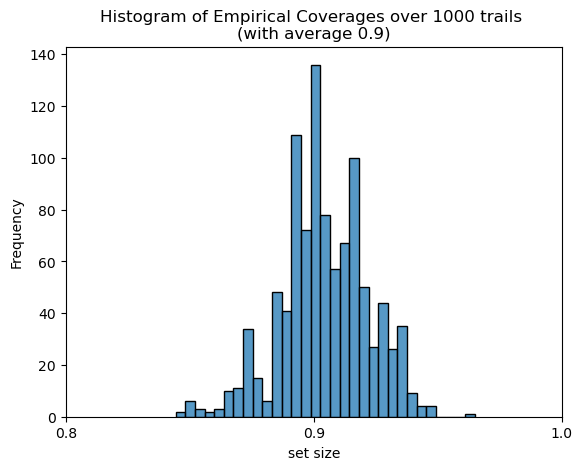

In [4]:
from CP import CP
nm = "InceptionV3"
## APS
### correctness check
cp = CP(nm, smx=smx, labels=labels, n_cali=1112, R=1000)
scores = cp.get_APS_score(smx, labels)
cp.cc(scores)

The empirical coverage is: 0.9195979899497487


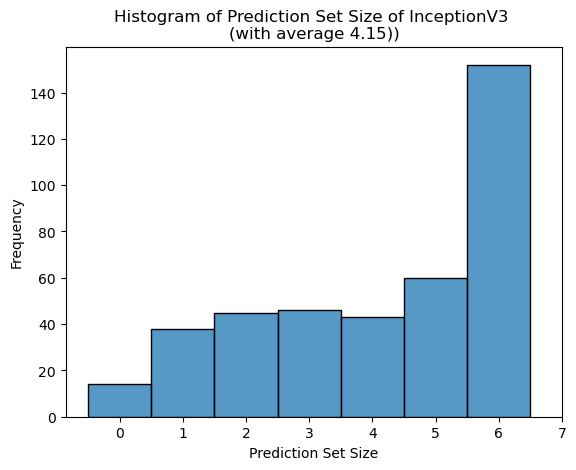

The feature-stratified coverage array is:
 [0.92307692 0.96428571 0.89655172 0.83333333 0.88       0.93777778
 0.83333333]
The size-stratified coverage array is:
 [0.92105263 0.86666667 0.97009967]


In [5]:
ps = cp.get_APS()
empirical_coverage = cp.get_sample_coverage()
cp.hist_SPS()
fsc = cp.get_fsc()
ssc = cp.get_ssc()

In [6]:
ec_list = []
sps_avg_list = []
fsc_list = []
ssc_list = []
for i in range(20):
    cp = CP(nm, smx=smx, labels=labels, n_cali=1112)
    ps = cp.get_APS()
    ec_list.append(cp.get_sample_coverage(pt=False))
    sps_avg_list.append(cp.hist_SPS(plot=False))
    fsc_list.append(cp.get_fsc(array=False))
    ssc_list.append(cp.get_ssc(array=False))
print(f"the empirical coverage for each data split is:\n {ec_list}")
print(f"the average size of prediction sets for each data split is:\n {sps_avg_list}")
print(f"the fsc metric for each data split is:\n {fsc_list}")
print(f"the ssc metric for each data split is:\n {ssc_list}")

the empirical coverage for each data split is:
 [0.9170854271356784, 0.9170854271356784, 0.8894472361809045, 0.9120603015075377, 0.8768844221105527, 0.9120603015075377, 0.9371859296482412, 0.9120603015075377, 0.8969849246231156, 0.9170854271356784, 0.9371859296482412, 0.9296482412060302, 0.9321608040201005, 0.8894472361809045, 0.8919597989949749, 0.9045226130653267, 0.8869346733668342, 0.8944723618090452, 0.8994974874371859, 0.8969849246231156]
the average size of prediction sets for each data split is:
 [4.09, 4.04, 4.04, 4.03, 4.0, 4.08, 4.12, 4.01, 3.9, 4.1, 4.18, 4.12, 4.26, 4.0, 4.0, 4.05, 4.06, 3.98, 4.1, 4.08]
the fsc metric for each data split is:
 [0.8333333333333334, 0.7272727272727273, 0.8, 0.8181818181818182, 0.6923076923076923, 0.75, 0.8947368421052632, 0.6666666666666666, 0.7777777777777778, 0.8181818181818182, 0.8627450980392157, 0.8181818181818182, 0.8870967741935484, 0.75, 0.75, 0.7142857142857143, 0.6923076923076923, 0.8, 0.8409090909090909, 0.6]
the ssc metric for ea

The empirical coverage is: 0.9020618556701031


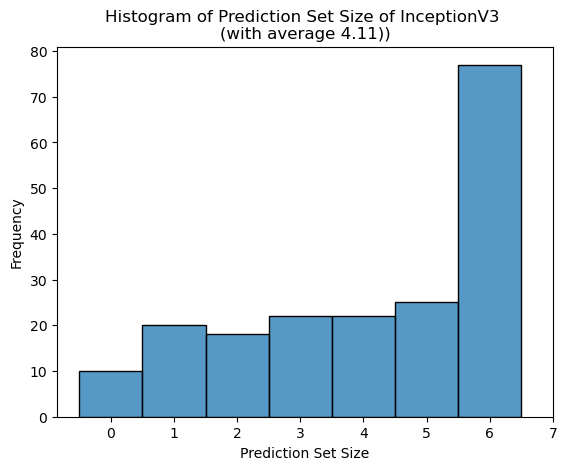

The feature-stratified coverage array is:
 [0.875      0.8        0.81818182 1.         1.         0.92361111
 1.        ]
The size-stratified coverage array is:
 [0.9        0.94444444 0.95890411]


In [7]:
## Conformal prediction with calibration data as the test dataset and validation data as the small validation dataset (did not use for training)
cp = CP(nm, cal_smx=smx, cal_labels=labels, val_smx=smx_val, val_labels=labels_val)
ps = cp.get_APS()
empirical_coverage = cp.get_sample_coverage()
cp.hist_SPS()
fsc = cp.get_fsc()
ssc = cp.get_ssc()

In [8]:
## RAPS
### CV for hyper parameters lam_reg and k_reg
cp = CP(nm, sc=1, smx=smx, labels=labels, n_cali=1112)
cp.cv_hypas()

Optimal parameters: lam_reg=1e-06, k_reg=2
Coverage: 0.8938545688545687, Average set size: 2.453185328185328


In [27]:
lam_reg=1e-6
k_reg=2

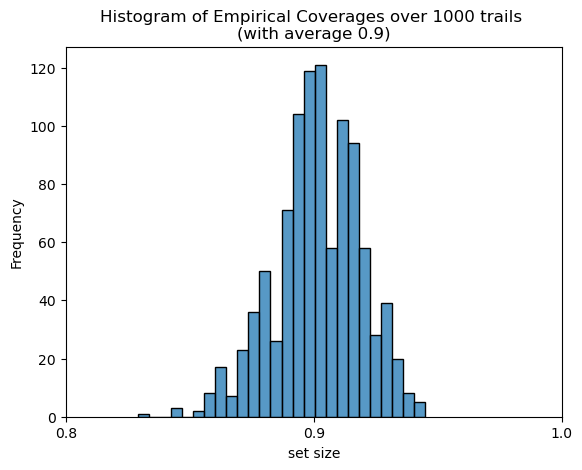

In [28]:
## correctness check
cp = CP(nm, sc=1, smx=smx, labels=labels, n_cali=1112, R=1000, lam_reg=lam_reg, k_reg=k_reg)
scores = cp.get_RAPS_score(heu_score=smx, lbs=labels)
cp.cc(scores)

The empirical coverage is: 0.9095477386934674


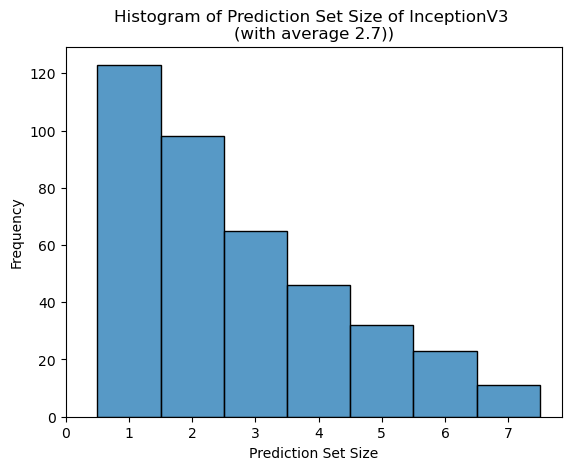

The feature-stratified coverage array is:
 [0.5        0.93939394 0.71428571 0.81818182 0.87234043 1.
 0.6       ]
The size-stratified coverage array is:
 [0.89430894 0.85714286 0.94915254]


In [29]:
ps = cp.get_RAPS()
empirical_coverage = cp.get_sample_coverage()
cp.hist_SPS()
fsc = cp.get_fsc()
ssc = cp.get_ssc()

In [30]:
ec_list = []
sps_avg_list = []
fsc_list = []
ssc_list = []
for i in range(20):
    cp = CP(nm, sc=1, smx=smx, labels=labels, n_cali=1112, k_reg=k_reg, lam_reg=lam_reg)
    ps = cp.get_RAPS()
    ec_list.append(cp.get_sample_coverage(pt=False))
    sps_avg_list.append(cp.hist_SPS(plot=False))
    fsc_list.append(cp.get_fsc(array=False))
    ssc_list.append(cp.get_ssc(array=False))
print(f"the empirical coverage for each data split is:\n {ec_list}")
print(f"the average size of prediction sets for each data split is:\n {sps_avg_list}")
print(f"the fsc metric for each data split is:\n {fsc_list}")
print(f"the ssc metric for each data split is:\n {ssc_list}")

the empirical coverage for each data split is:
 [0.8919597989949749, 0.9020100502512562, 0.8693467336683417, 0.8969849246231156, 0.914572864321608, 0.8592964824120602, 0.8869346733668342, 0.8944723618090452, 0.9095477386934674, 0.9120603015075377, 0.9271356783919598, 0.871859296482412, 0.8994974874371859, 0.9120603015075377, 0.8819095477386935, 0.8944723618090452, 0.8844221105527639, 0.8969849246231156, 0.9045226130653267, 0.9195979899497487]
the average size of prediction sets for each data split is:
 [2.67, 2.63, 2.52, 2.58, 2.78, 2.39, 2.52, 2.59, 2.67, 2.66, 2.9, 2.65, 2.68, 2.6, 2.5, 2.55, 2.58, 2.65, 2.78, 2.69]
the fsc metric for each data split is:
 [0.6428571428571429, 0.5, 0.4, 0.625, 0.5333333333333333, 0.5, 0.36363636363636365, 0.3076923076923077, 0.5454545454545454, 0.4, 0.6, 0.5384615384615384, 0.6, 0.5, 0.5625, 0.3333333333333333, 0.5625, 0.5714285714285714, 0.6, 0.4666666666666667]
the ssc metric for each data split is:
 [0.8349514563106796, 0.8640776699029126, 0.826923

The empirical coverage is: 0.9226804123711341


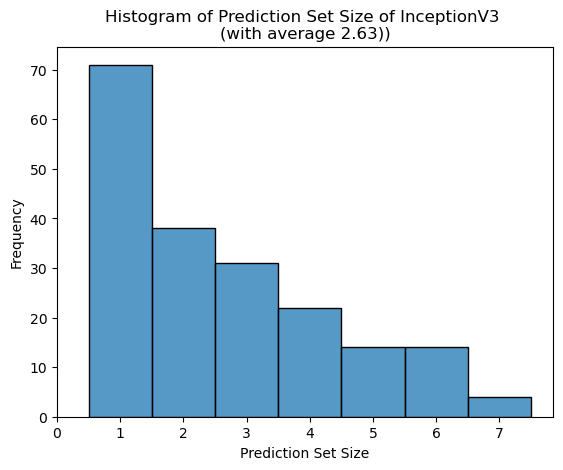

The feature-stratified coverage array is:
 [0.5        0.86666667 0.77272727 1.         1.         0.97916667
 0.66666667]
The size-stratified coverage array is:
 [0.91549296 0.94736842 0.91764706]


In [31]:
## Conformal prediction with calibration data as the test dataset and validation data as the small validation dataset (did not use for training)
cp = CP(nm, sc=1, cal_smx=smx, cal_labels=labels, val_smx=smx_val, val_labels=labels_val, k_reg=k_reg, lam_reg=lam_reg)
ps = cp.get_RAPS()
empirical_coverage = cp.get_sample_coverage()
cp.hist_SPS()
fsc = cp.get_fsc()
ssc = cp.get_ssc()